## Домашнее задание 7

- Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- Сделать обзорный анализ выбранного датасета
- Обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для: 
- - всего тестового набора данных (summary_plot - дать интерпретацию)
- - для 5 случайных объектов из тестового набора

### Датасет по кредитному скорингу

#### Описание датасета



Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита

Current Credit Balance - текущий кредитный баланс

Monthly Debt - ежемесячный долг

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [796]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

### EDA

In [797]:
df = pd.read_csv('data.csv')

In [798]:
df.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00000,NaN,0.00000,11.00000,26.30000,685960.00000,1.00000,NaN,1.00000,debt consolidation,Short Term,99999999.00000,47386.00000,7914.00000,749.00000,0
1,Own Home,1025487.00000,10+ years,0.00000,15.00000,15.30000,1181730.00000,0.00000,NaN,0.00000,debt consolidation,Long Term,264968.00000,394972.00000,18373.00000,737.00000,1
2,Home Mortgage,751412.00000,8 years,0.00000,11.00000,35.00000,1182434.00000,0.00000,NaN,0.00000,debt consolidation,Short Term,99999999.00000,308389.00000,13651.00000,742.00000,0


In [799]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Months since last delinquent - больше половины пропущенных. Простым заполнением не обойдется, либо удаляем признак, либо запоняем более хитрым способом.
Annual Income, Years in current job, Bankruptcies, Credit Score - также много пропущенных значений, либо заполняем статистикой (медиана\среднее), либо тоже через более хитрый способ.

In [800]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.00000,7500.00000,7500.00000,7500.00000,7500.00000,7500.00000,3419.00000,7486.00000,7500.00000,7500.00000,7500.00000,5943.00000,7500.00000
mean,1366391.72017,0.03013,11.13093,18.31747,945153.72747,0.17000,34.69260,0.11715,11873177.44507,289833.23520,18314.45413,1151.08750,0.28173
std,845339.19963,0.27160,4.90892,7.04195,16026216.67085,0.49860,21.68881,0.34719,31926122.97473,317871.38238,11926.76467,1604.45142,0.44987
min,164597.00000,0.00000,2.00000,4.00000,0.00000,0.00000,0.00000,0.00000,11242.00000,0.00000,0.00000,585.00000,0.00000
25%,844341.00000,0.00000,8.00000,13.50000,279229.50000,0.00000,16.00000,0.00000,180169.00000,114256.50000,10067.50000,711.00000,0.00000
50%,1168386.00000,0.00000,10.00000,17.00000,478159.00000,0.00000,32.00000,0.00000,309573.00000,209323.00000,16076.50000,731.00000,0.00000
75%,1640137.00000,0.00000,14.00000,21.80000,793501.50000,0.00000,50.00000,0.00000,519882.00000,360406.25000,23818.00000,743.00000,1.00000
max,10149344.00000,7.00000,43.00000,57.70000,1304726170.00000,7.00000,118.00000,4.00000,99999999.00000,6506797.00000,136679.00000,7510.00000,1.00000


- Maximum Open Credit похоже на выбросы
- Current Loan Amount подозрительное макс значение
- Current Credit Balance - посмотреть выброс или нет.
- Credit score -  посмотреть частоту значений, возможно верхняя граница это просто ошибка лишей цифры.
- Current Credit Balance, Monthly Debt - посмотреть 0 значения.

In [801]:
df['Credit Default'].value_counts(normalize=True)

0   0.71827
1   0.28173
Name: Credit Default, dtype: float64

Целевой класс не сбалансирован.

In [802]:
df['Current Loan Amount'].value_counts()

99999999.00000    870
218064.00000        6
89298.00000         6
222926.00000        5
265826.00000        5
                 ... 
351626.00000        1
212498.00000        1
187682.00000        1
108922.00000        1
26928.00000         1
Name: Current Loan Amount, Length: 5386, dtype: int64

<AxesSubplot:>

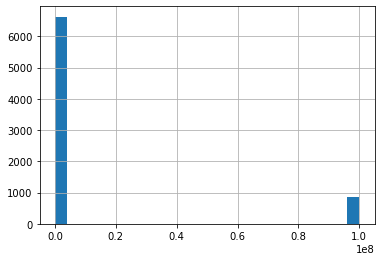

In [803]:
df['Current Loan Amount'].hist(bins=25)

На сколько я знаю, обычно таким образом ставят метку на наблюдении. Либо -1, либо 99999+.

In [804]:
df.loc[df['Current Loan Amount'] == 99999999, 'Credit Default'].value_counts()

0    870
Name: Credit Default, dtype: int64

Ну вот, все "помеченные" это 0 класс.

<AxesSubplot:>

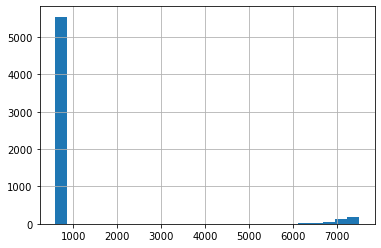

In [805]:
df["Credit Score"].hist(bins=25)

In [806]:
df.loc[df['Credit Score'] > 1000, 'Credit Default'].value_counts()

1    400
Name: Credit Default, dtype: int64

Тоже самое, не ошибка, а метка. 

- Посмотрим признак Months since last delinquent.

Признак не простой, вероятнее всего пропущенные значения, это клиенты которые никогда не просрачивали кредит, и важно это правильно объяснить модели т.к. это весомый довод выдать кредит. Мы не можем написать 0, т.к. это значит, что просрока была в это м месяце. Нужно большое число. Можно взять максимальное число из признака и также создать доп признак.

In [807]:
df.loc[df['Months since last delinquent'].notnull()]['Credit Default'].value_counts(normalize=True)

0   0.71249
1   0.28751
Name: Credit Default, dtype: float64

In [808]:
df.loc[df['Months since last delinquent'].isnull()]['Credit Default'].value_counts(normalize=True)

0   0.72311
1   0.27689
Name: Credit Default, dtype: float64

В целом почти нет разницы.

- Посмотрим на категориальные переменные в разрезе целевой переменной

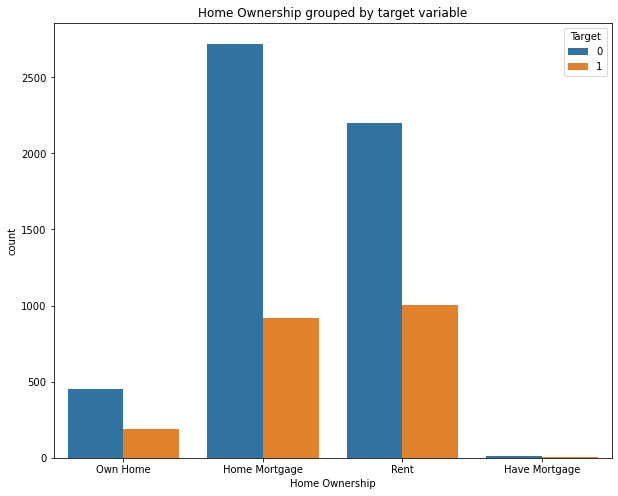

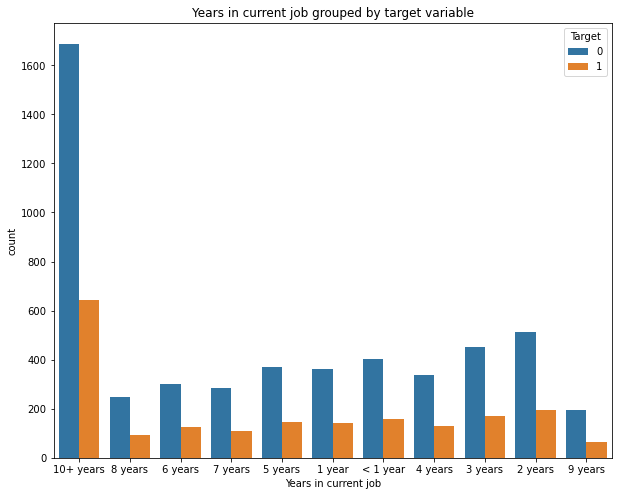

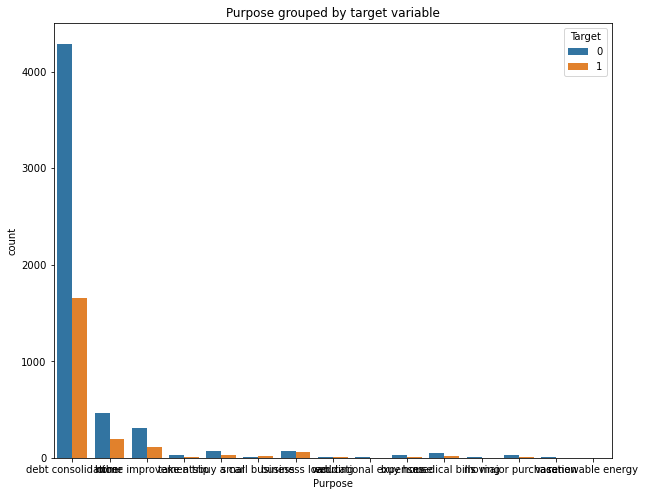

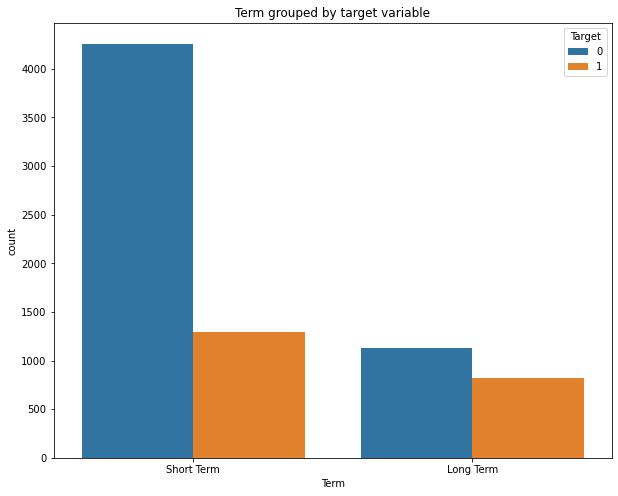

In [809]:
categorical_columns = df.select_dtypes(exclude='number').columns.to_list()
for col in categorical_columns:
    plt.figure(figsize=(10, 8))

    sns.countplot(x=col, hue='Credit Default', data=df)
    plt.title(f'{col} grouped by target variable')
    plt.legend(title='Target', loc='upper right')

    plt.show()

Из всех признаков самым интересным оказался "Term". Видно, что те, кто брал кредит на долгий срок, не могли вернуть его на много чаще. 

- Посмотрим на вещественные переменные в разрезе целевой переменной

In [810]:
continuous_columns = df.select_dtypes(include='number').columns.to_list()

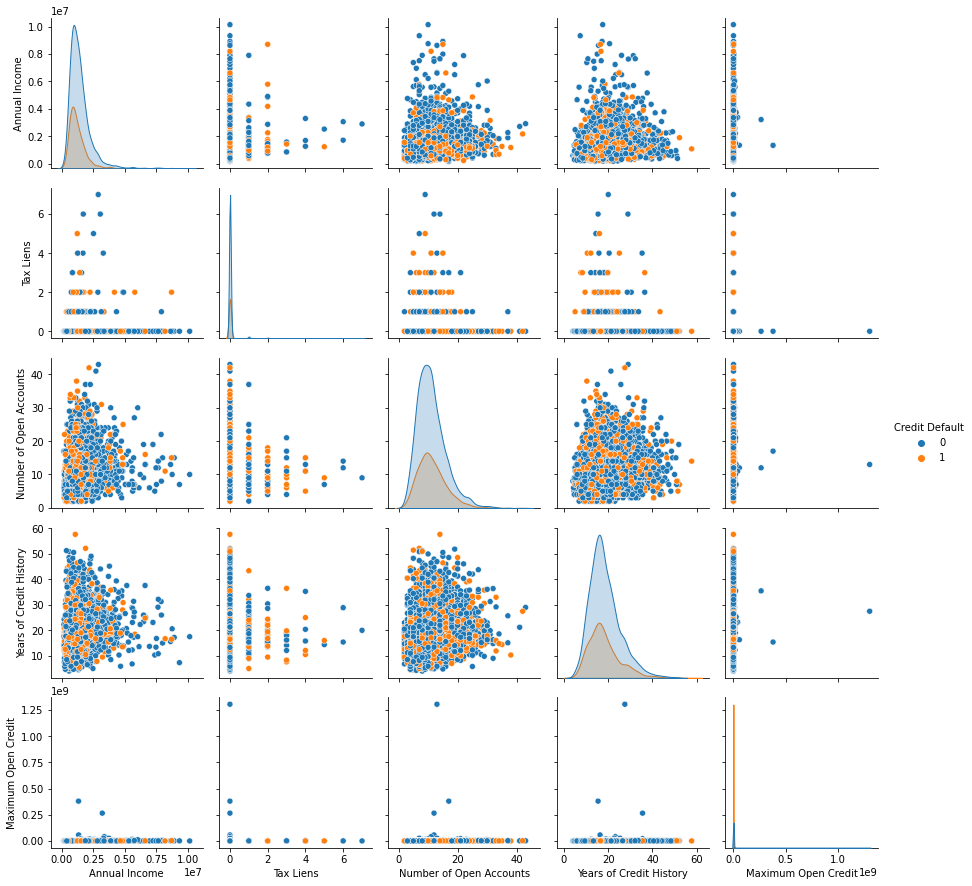

In [811]:
sns.pairplot(df[continuous_columns[:5] + ["Credit Default"]], hue="Credit Default")

- Просматривается небольшая линейность между Annual income и (Number of open account, Years of Credit history). В целом пока по целевому значению распределения не выделяются.


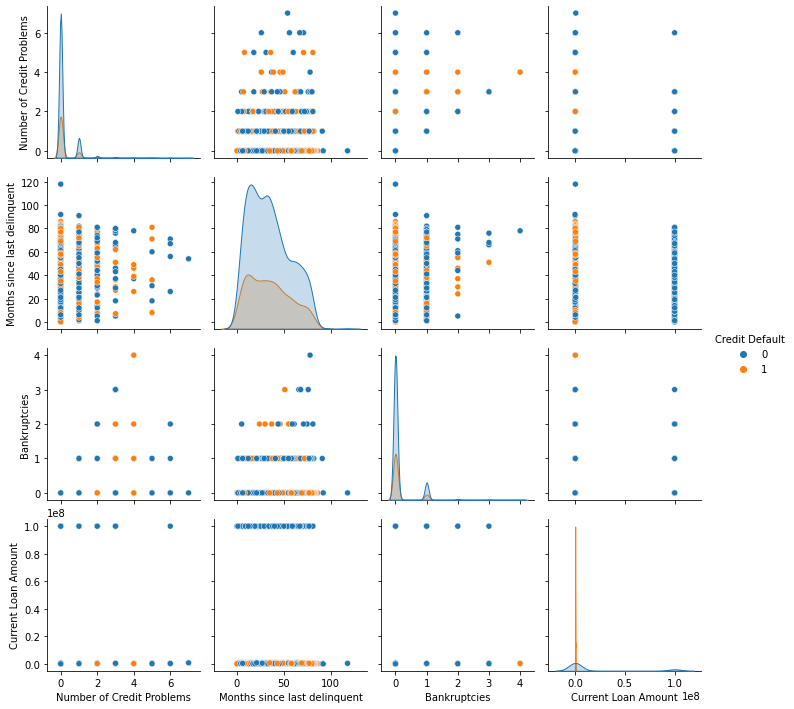

In [812]:
sns.pairplot(df[continuous_columns[5:9] + ["Credit Default"]], hue="Credit Default")

- Current Loan Ammount видно метку, о которой писал выше

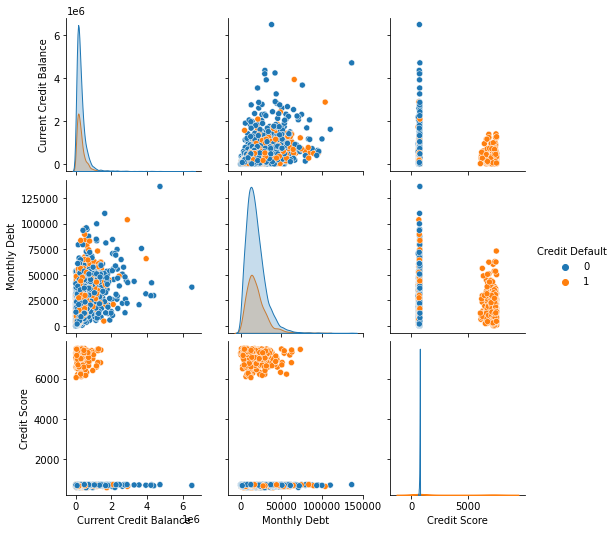

In [813]:
sns.pairplot(df[continuous_columns[9:]], hue="Credit Default")

- Также видно метку Credit score

- На мой взгляд стоит использовать алгоритм на основе деревьев, т.к. он хорошо распознает метки в наблюдениях.

### Pipline (в итоге не пригодился, но оставлю для потомков)

In [814]:
df = pd.read_csv('data.csv')
#df.drop('Months since last delinquent', axis = 1, inplace=True) 
df.dropna(inplace=True)

In [815]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2585 entries, 6 to 7496
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2585 non-null   object 
 1   Annual Income                 2585 non-null   float64
 2   Years in current job          2585 non-null   object 
 3   Tax Liens                     2585 non-null   float64
 4   Number of Open Accounts       2585 non-null   float64
 5   Years of Credit History       2585 non-null   float64
 6   Maximum Open Credit           2585 non-null   float64
 7   Number of Credit Problems     2585 non-null   float64
 8   Months since last delinquent  2585 non-null   float64
 9   Bankruptcies                  2585 non-null   float64
 10  Purpose                       2585 non-null   object 
 11  Term                          2585 non-null   object 
 12  Current Loan Amount           2585 non-null   float64
 13  Cur

In [816]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Credit Default' ], axis = 1), df['Credit Default'], test_size=0.3, random_state=7)

In [817]:
continuous_columns = X_train.select_dtypes(include='number').columns.to_list()
categorical_columns = X_train.select_dtypes(exclude='number').columns.to_list()

In [818]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key, drop_first=True).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key, drop_first=True)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    
class CatNaNInputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        
        self.frequent_constant = 'None'

    def fit(self, X, y=None):
        self.frequent_constant = X.mode()[0]
        return self

    def transform(self, X):
        X = X.fillna(self.frequent_constant)
        return X

class OneFeatureNaNInputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.flag = 9999

    def fit(self, X, y=None):

        return self

    def transform(self, X):
        X = X.fillna(self.flag)
        return X
    
class NumericPower(BaseEstimator, TransformerMixin):
    def __init__(self, key, p = 2):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        B = [self.key + str(i) for i in range(1, self.p)]
        self.columns = B + ['log']
        return self

    def transform(self, X):
        Xp = X.values.reshape(-1,1)
        for i in range(2, self.p):
            Xp = np.hstack([Xp,(X.values.reshape(-1,1) ** i).astype(float)])

        Xp = np.hstack([Xp, np.log(X.values.reshape(-1,1) + 1).astype(float)])    
        B = pd.DataFrame(data = Xp, index = X.index,columns =[self.columns] )
        return B[self.columns]     

In [819]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('nan_inputer', CatNaNInputer()),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                
                ('NAN', SimpleImputer(strategy='median')),
                
        
                
            ])
    
    final_transformers.append((cont_col, cont_transformer))
    
flag_transformer = Pipeline([
            ('selector', NumberSelector(key='Months since last delinquent')),
            ('NAN', OneFeatureNaNInputer())

        ])

# final_transformers.append(('Months since last delinquent', flag_transformer))

In [820]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [821]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [822]:
weights = y_train.value_counts(normalize=True).to_dict()

In [823]:
#model = xgb.XGBClassifier(random_state=7)
#model = GradientBoostingClassifier(random_state=7)
model = RandomForestClassifier(random_state=7, class_weight = weights)

In [824]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', model)
])

In [825]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Home Ownership',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Home '
                                                                                         'Ownership')),
                                                                 ('nan_inputer',
                                                                  CatNaNInputer()),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Home '
                                                                                 'Ownership'))])),
                                                ('Years in current job',
                                                 Pipeline(steps=[('selector',
                                                

In [826]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')


Best Threshold=0.4, F-Score=0.553, Precision=0.635, Recall=0.490


- По итогу, получилось, что любые манипуляции по заполнению пропущенных данных приводило к ухудшению качества, даже не смотря на то, что при удалении всех пропущенных, данных стало в 3 раза меньше.

### SHAP

In [856]:
df = pd.read_csv('data.csv')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [857]:
df = pd.get_dummies(df, drop_first=True)

In [858]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Credit Default' ], axis = 1), df['Credit Default'], test_size=0.3, random_state=7)

In [859]:
model = RandomForestClassifier(random_state=7)

In [860]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=7)

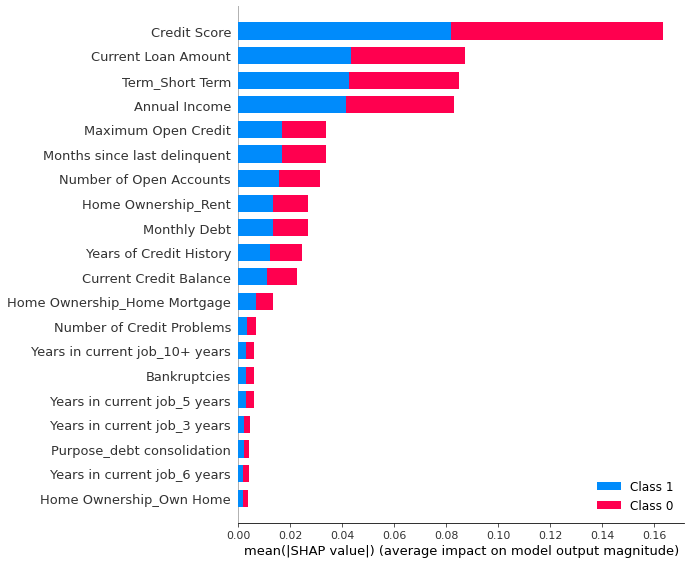

In [898]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

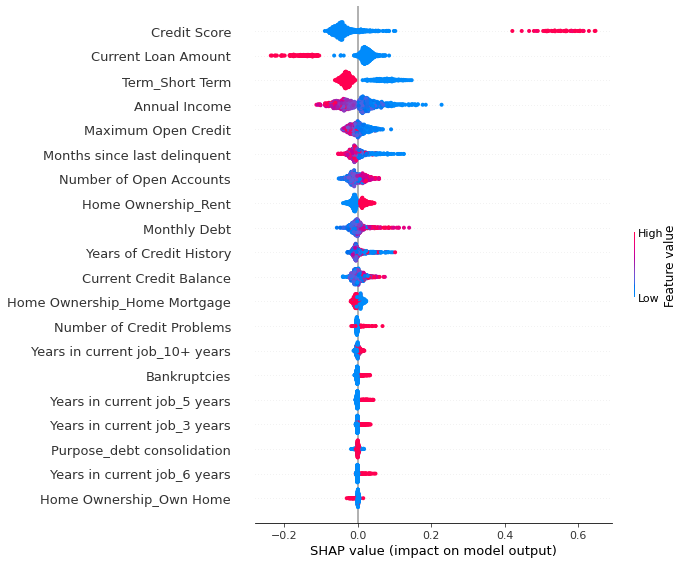

In [862]:
shap_values = shap_values[1]
shap.summary_plot(shap_values, X_test)

- По большей части  важность признаков подтверждают то, что я писал в EDA.
- Мне кажется в данном датасете, изза присутствующих меток в Credit score и Curren Loan Amount эти признаки сильно выделяются. Видно, что модель сильно уверена, что класс = 1 если Credit score большой, и класс = 0, если Curren Loan Amount большой.
- Бинарный признак Term хорошо разделяет датасет, все, кто брал на короткий срок, повышают вероятность не просрочить кредит (т.е целевой = 0), кто брал на длинный, повышают вероятность просрочки.
- Annual income - зарплата - выглядит логично, чем больше ЗП тем вероятнее, что человек принесет денежку обратно в банк.
- Максимальный открытый кредит - чем больше кредит был до этого открыт (закрыт ли?), тем, вероятно больше возможность закрыть следующий кредит.
- Месяцев с последней просрочки платежа. Получается, чем больше времени прошло с момента просрочки, тем меньше вероятность увидеть клиента с оплатой.
- Если клиент снимает квартиру, то больше вероятность просрочить кредит.
- Ежемесячный платеж. Интересный признак, получается, чем больше клиент платит в месяц, тем больше вероятность просрочки. Т.е. может имеет смысл увеличить срок кредита, например.

In [899]:
explainer = shap.TreeExplainer(model)
shap_values_all = explainer.shap_values(X_train)

In [901]:
# !!! Для рандомфореста нужно указывать класс предикта explainer.expected_value[1], shap_values_all[1]

expected_value = explainer.expected_value[1]
shap_values = shap_values_all[1]

In [902]:
shap.initjs()
idx = 1
shap.force_plot(expected_value, shap_values[idx], X_train.iloc[idx])

- Тут видно, что метка Credit score делает за нас всю работу

In [903]:
shap.initjs()
idx = 10
shap.force_plot(expected_value, shap_values[idx], X_train.iloc[idx])

- В данном примере кредитный рейтинг много больше среднего и короткий займ + малая сумма выплат перевешивают к 0, хотя Время просрочки совсем маленькое, что по идее должно тоже говоирть, что скорее будет 0 таргет. Но видимо признак довольно шусный.

In [904]:
shap.initjs()
idx = 20
shap.force_plot(expected_value, shap_values[idx], X_train.iloc[idx])

- Маленькая зарплата а размер кредите выше медианы говори о большой вероятности не возврата.

In [905]:
shap.initjs()
idx = 30
shap.force_plot(expected_value, shap_values[idx], X_train.iloc[idx])

- Большая зарплата, большой рейтинг и быстрый займ дает большую уверенность возврата кредита. 

In [906]:
shap.initjs()
idx = 40
shap.force_plot(expected_value, shap_values[idx], X_train.iloc[idx])

 - Большая зарплата, большой рейтинг и большой предыдущий займ дает большую уверенность возврата кредита, однако долгий кредит снижает нашу уверенность. 